# Normalizing flows - A toy example

In this notebook, it is implemented a simple normalizing flow to sample from two moons.

In [344]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from sklearn.datasets import make_moons

In [311]:
class MLP(nn.Module):
    '''
    Multilayer perceptron module.
    '''
    def __init__(self, in_dim, hidden_dim = 128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim), 
            nn.LeakyReLU(), 
            nn.Linear(hidden_dim, hidden_dim), 
            nn.LeakyReLU(), 
            nn.Linear(hidden_dim, in_dim)
        )

    def forward(self, x):
        return self.net(x)


class RealNVPLayer(nn.Module):
    '''
    Real NVP layer module.
    '''
    def __init__(self, dim, mask):
        super().__init__()
        
        # Uses MLP module as scale and
        # translate neural networks
        self.scale_net = MLP(dim)
        self.translate_net = MLP(dim)

        # Defines mask to implement
        # coupling layers
        self.mask = nn.Parameter(mask, requires_grad=False)

    def forward(self, x):
        # Forward transformation
        x_masked = x * self.mask
        s = self.scale_net(x_masked) * (1 - self.mask)
        t = self.translate_net(x_masked) * (1 - self.mask)
        z = x_masked + (1 - self.mask) * (x * torch.exp(s) + t)
        return z

    def inverse(self, y):
        # Inverse transformation
        y_masked = y * self.mask
        s = self.scale_net(y_masked) * (1 - self.mask)
        t = self.translate_net(y_masked) * (1 - self.mask)
        x = y_masked + (1 - self.mask) * ((y - t) * torch.exp(-s))
        log_det_J = torch.sum(s, dim = 1)
        return x, log_det_J


class RealNVP(nn.Module):
    '''
    Real NVP module.
    Consists of multiple Real NVP layers.
    '''
    def __init__(self, dim, n_layers, base_dist):
        super().__init__()
        self.dim = dim
        self.base_dist = base_dist
        self.layers = nn.ModuleList()
        for i in range(n_layers):
            # Create masks
            mask = torch.tensor(
                [i%2, (i + 1)%2], 
                dtype=torch.float32
            )
            # Add Real NVP layer
            self.layers.append(RealNVPLayer(self.dim, mask))

    def forward(self, x):
        # Forward transformation
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def inverse(self, z):
        # Inverse transformation
        log_det_J = torch.zeros(z.size(0))
        for layer in reversed(self.layers):
            z, log_det = layer.inverse(z)
            log_det_J -= log_det
        return z, log_det_J

    def log_prob(self, x):
        # Computes the log pdf of the final samples
        z, log_det = self.inverse(x)
        return self.base_dist.log_prob(z) + log_det
        
    def sample(self, n_samples): 
        # Sample from the final distribution
        z = self.base_dist.sample((n_samples, 1))
        x = self.forward(z.resize(n_samples, self.dim))
        return x

In [312]:
def batch(size, data):
    '''
    Select a batch of the data.
    '''
    N = data.shape[0]
    rand = np.random.permutation(N)
    selected_lines = rand[-size:]
    return data[selected_lines,:]

def opt_flow(flow, data, lr=1e-4, nIter=500, verbose=True):
    '''
    Optimize the flow to sample from the distribution
    that originated the data.
    Returns the flow with optimized parameters.
    '''
    optimizer = torch.optim.Adam(
        [p for p in flow.parameters() if p.requires_grad == True], 
        lr=lr
    )
    for t in range(nIter+1):    
        cur_batch = batch(100, data).astype(np.float32)
        
        loss = -flow.log_prob(torch.from_numpy(cur_batch)).mean()

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        if t % 50 == 0 and verbose:
            print('iter %s:' % t, 'loss = %.3f' % loss)
    return flow

In [313]:
# Generate data
moons, _ = make_moons(n_samples=1000, noise=0.1, random_state=42)

In [314]:
# Create and optimize flow
normal = distributions.MultivariateNormal(
    torch.zeros(2), 
    torch.eye(2)
)
flow = RealNVP(dim=2, n_layers=5, base_dist=normal)
flow = opt_flow(flow, moons, lr=1e-3, nIter=1000, verbose=True)

iter 0: loss = 2.525
iter 50: loss = 1.428
iter 100: loss = 1.509
iter 150: loss = 1.305
iter 200: loss = 1.300
iter 250: loss = 1.444
iter 300: loss = 1.278
iter 350: loss = 1.184
iter 400: loss = 1.139
iter 450: loss = 1.168
iter 500: loss = 1.139
iter 550: loss = 1.222
iter 600: loss = 1.218
iter 650: loss = 1.296
iter 700: loss = 1.168
iter 750: loss = 1.132
iter 800: loss = 1.194
iter 850: loss = 1.154
iter 900: loss = 1.080
iter 950: loss = 0.912
iter 1000: loss = 0.908


Now we can check the behavior of the trained flow by plotting the samples after each transformation.

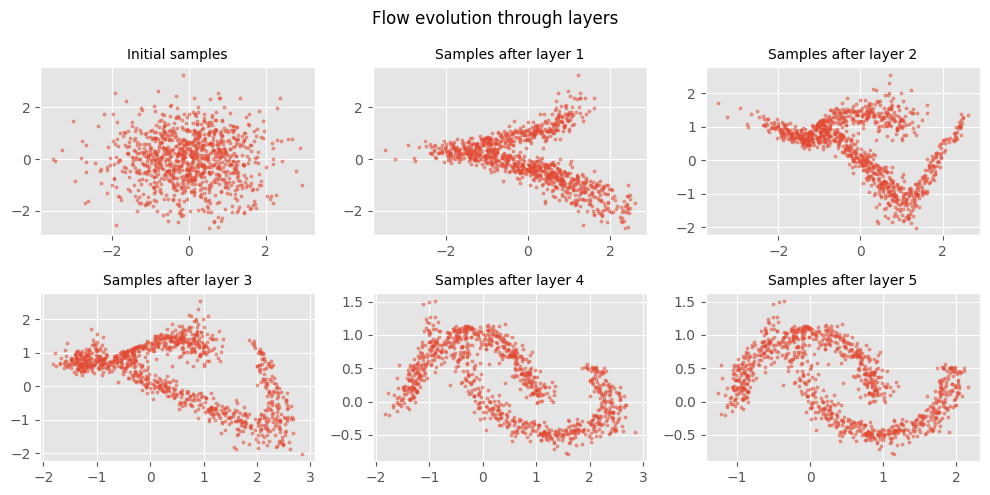

In [315]:
normal_samples = torch.randn(1000,2)

fig, ax = plt.subplots(2,3,figsize=(10,5))
layers = [normal_samples]

ax[0,0].scatter(
    normal_samples[:,0],
    normal_samples[:,1],
    s=5,alpha=0.5
)
ax[0,0].set_title('Initial samples',size=10)

for i,layer in enumerate(flow.layers):
    layers.append(layer.forward(layers[-1]).detach())
    ax[(i+1)//3,(i+1)%3].scatter(
        layers[-1].numpy()[:,0],
        layers[-1].numpy()[:,1],
        s=5, alpha=0.5
    )
    ax[(i+1)//3,(i+1)%3].set_title(f'Samples after layer {i+1}',size=10)
fig.suptitle('Flow evolution through layers')
plt.tight_layout()
plt.savefig('./figs/flow_evol_two_moons.png')

Plotting the obtained samples against the original data:

Text(0.5, 1.0, 'Obtained samples')

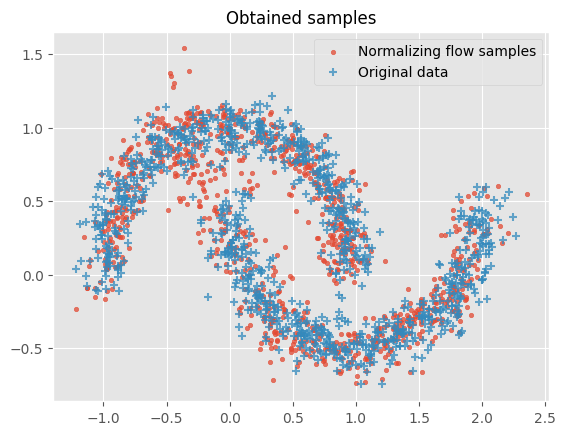

In [328]:
samples = flow.sample(1000)

plt.scatter(
    samples.detach()[:,0],
    samples.detach()[:,1],
    s=10,alpha=.75,
    label="Normalizing flow samples"
)
plt.scatter(
    moons[:,0],
    moons[:,1],
    alpha=.75, marker='+',
    label="Original data"
)
plt.legend()
plt.title("Obtained samples", size=12)

Finally, it is possible to check the inverse transformation by applying it to the original data.

In [333]:
u_samples, _ = flow.inverse(
    torch.tensor(moons, dtype=torch.float32)
)

Text(0.5, 1.0, 'Samples obtained by transforming the two moons data\nusing the inverse flow')

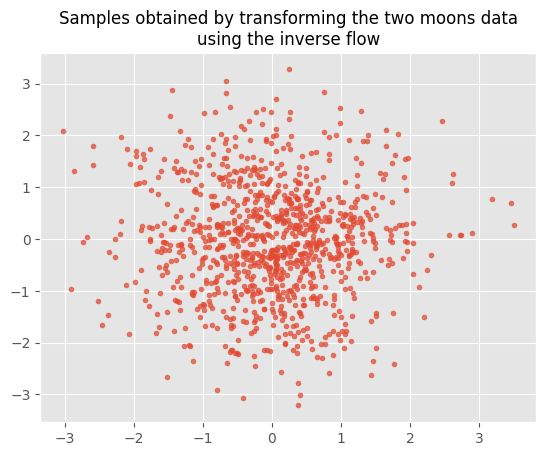

In [339]:
plt.scatter(
    u_samples.detach().numpy()[:,0],
    u_samples.detach().numpy()[:,1],
    s=12,alpha=.75
)
plt.title("Samples obtained by transforming the two moons data\nusing the inverse flow", size=12)